In [15]:
import pandas as pd
import numpy as np
import os
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b
from keras.applications.vgg19 import VGG19
#vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
#vgg19 = VGG19(include_top = False, weights=vgg19_weights)
print(os.listdir("../input"))
import torch

['content-pic', 'best-artworks-of-all-time']


In [16]:
import tensorflow as tf
from tensorflow.keras.applications import vgg19, inception_v3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
artists_df = pd.read_csv('/kaggle/input/best-artworks-of-all-time/artists.csv')  # assumes 'artist' column exists
artist_labels = sorted(artists_df['name'].unique())

In [11]:
StylePath = '../input/best-artworks-of-all-time/images/images/'
ContentPath = '../input/content-pic/'

In [12]:
base_image_path = ContentPath+'Screenshot 2025-02-19 at 7.02.21PM.png'
style_image_path = StylePath+'Pablo_Picasso/Pablo_Picasso_92.jpg'

In [25]:
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

## VGG

In [28]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

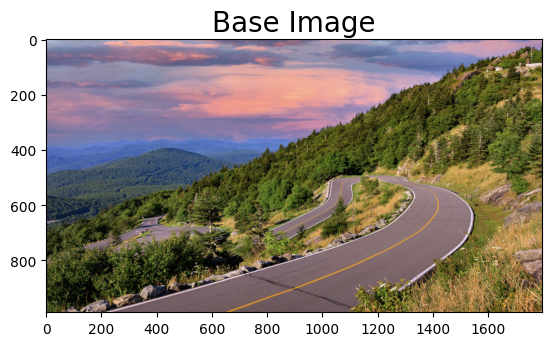

In [29]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(base_image_path)
plt.imshow(img1)

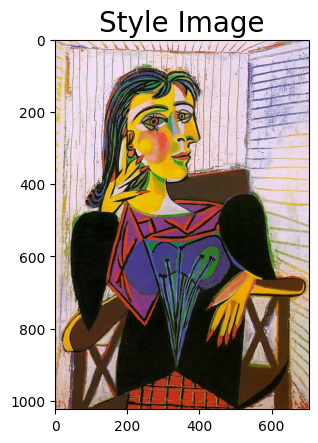

In [30]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = load_img(style_image_path)
plt.imshow(img1)

In [4]:
def preprocess_image(image_path, img_nrows, img_ncols, model_name):
    """Load and preprocess the image for a given model."""
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    if model_name == 'vgg19':
        img = vgg19.preprocess_input(img)
    elif model_name == 'inceptionv3':
        img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x, img_nrows, img_ncols, model_name):
    """Revert a preprocessed tensor into a valid image."""
    x = x.reshape((img_nrows, img_ncols, 3))
    if model_name == 'vgg19':
        # VGG19 preprocess subtracts mean RGB; revert that
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
        # Convert from BGR to RGB
        x = x[:, :, ::-1]
    elif model_name == 'inceptionv3':
        # InceptionV3 scales input to [-1, 1]
        x = (x + 1) * 127.5
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [5]:
# ----------------------------
# Loss Functions
# ----------------------------
def gram_matrix(x):
    """Compute the Gram matrix for an image tensor (H, W, C)."""
    # Permute dimensions to (C, H, W) and then reshape to (C, H*W)
    x = tf.transpose(x, perm=[2, 0, 1])
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, features, transpose_b=True)
    return gram

def get_content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

def get_style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    return tf.reduce_sum(tf.square(S - C))


In [6]:
def create_feature_extractor(model_name, img_nrows, img_ncols):
    """Return a model that outputs a list of style and content features.
    
       For VGG19, we use 'block5_conv2' for content and
       ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
       for style. For InceptionV3 we pick some "mixed" layers.
    """
    if model_name == 'vgg19':
        content_layer = 'block5_conv2'
        style_layers = ['block1_conv1', 'block2_conv1', 
                        'block3_conv1', 'block4_conv1', 
                        'block5_conv1']
        base_model = vgg19.VGG19(include_top=False, weights='imagenet',
                                 input_shape=(img_nrows, img_ncols, 3))
    elif model_name == 'inceptionv3':
        content_layer = 'mixed7'
        style_layers = ['mixed0', 'mixed1', 'mixed2', 'mixed3']
        base_model = inception_v3.InceptionV3(include_top=False, weights='imagenet',
                                               input_shape=(img_nrows, img_ncols, 3))
    else:
        raise ValueError("model_name must be either 'vgg19' or 'inceptionv3'.")
    style_outputs = [base_model.get_layer(name).output for name in style_layers]
    content_output = base_model.get_layer(content_layer).output
    model = tf.keras.Model(inputs=base_model.input,
                           outputs=style_outputs + [content_output])
    model.trainable = False
    return model, content_layer, style_layers


In [7]:
def compute_loss_and_grads(combination_image, base_image, style_image,
                           feature_extractor, content_weight, style_weight):
    """Compute total loss and gradients for the generated image."""
    with tf.GradientTape() as tape:
        # Concatenate images along the batch (0th) dimension:
        # Order: base image, style image, combination image
        input_tensor = tf.concat([base_image, style_image, combination_image], axis=0)
        features = feature_extractor(input_tensor)
        num_style_layers = len(features) - 1  # last output is content feature
        style_features = features[:num_style_layers]
        content_feature = features[-1]
        
        # Utility: extract image at given index from a tensor output.
        def get_slice(x, index):
            return x[index, :, :, :]
        
        base_content = get_slice(content_feature, 0)
        combination_content = get_slice(content_feature, 2)
        c_loss = get_content_loss(base_content, combination_content)
        
        s_loss = 0
        for style_feat in style_features:
            style_target = get_slice(style_feat, 1)
            combination_style = get_slice(style_feat, 2)
            s_loss += get_style_loss(style_target, combination_style)
        s_loss /= num_style_layers
        
        total_loss = content_weight * c_loss + style_weight * s_loss
    grads = tape.gradient(total_loss, combination_image)
    return total_loss, grads

In [8]:
class Evaluator:
    def __init__(self, base_image, style_image, combination_image,
                 feature_extractor, content_weight, style_weight):
        self.base_image = base_image
        self.style_image = style_image
        self.combination_image = combination_image
        self.feature_extractor = feature_extractor
        self.content_weight = content_weight
        self.style_weight = style_weight
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        x = x.reshape(self.combination_image.shape)
        self.combination_image.assign(x)
        loss, grads = compute_loss_and_grads(self.combination_image, self.base_image, 
                                             self.style_image, self.feature_extractor, 
                                             self.content_weight, self.style_weight)
        self.loss_value = loss.numpy().astype('float64')
        self.grads_values = grads.numpy().flatten().astype('float64')
        return self.loss_value

    def grads(self, x):
        return self.grads_values

In [9]:
def run_style_transfer(base_image_path, style_image_path, model_name='vgg19',
                       iterations=10, content_weight=0.025, style_weight=1.0, img_nrows=400):
    """Execute style transfer and return the final stylized image."""
    # Determine image dimensions (maintaining aspect ratio)
    width, height = load_img(base_image_path).size
    img_ncols = int(width * img_nrows / height)
    
    # Load and preprocess images.
    base_image_np = preprocess_image(base_image_path, img_nrows, img_ncols, model_name)
    style_image_np = preprocess_image(style_image_path, img_nrows, img_ncols, model_name)
    
    # Create tensors
    base_image = tf.constant(base_image_np, dtype=tf.float32)
    style_image = tf.constant(style_image_np, dtype=tf.float32)
    # Initialize the combination image with the base image.
    combination_image = tf.Variable(base_image_np, dtype=tf.float32)
    
    # Create the feature extractor model.
    feature_extractor, _, _ = create_feature_extractor(model_name, img_nrows, img_ncols)
    
    # Wrap loss and gradients for LBFGS.
    evaluator = Evaluator(base_image, style_image, combination_image,
                          feature_extractor, content_weight, style_weight)
    
    # Flatten initial combination image for the optimizer.
    x_opt = combination_image.numpy().flatten()
    
    for i in range(iterations):
        print(f"Start of iteration {i}")
        x_opt, min_val, info = fmin_l_bfgs_b(evaluator.loss, x_opt,
                                             fprime=evaluator.grads,
                                             maxfun=20, disp=True)
        print(f"Current loss value: {min_val}")
    
    # Reshape and deprocess the best image.
    best_img = x_opt.reshape(combination_image.shape)
    final_img = deprocess_image(best_img, img_nrows, img_ncols, model_name)
    return final_img


In [17]:
result_image = run_style_transfer(base_image_path, style_image_path, model_name='vgg19', iterations=3)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Start of iteration 0
Current loss value: 5.958449769345656e+21
Start of iteration 1
Current loss value: 2.765238881653109e+21
Start of iteration 2
Current loss value: 1.7401872368412624e+21


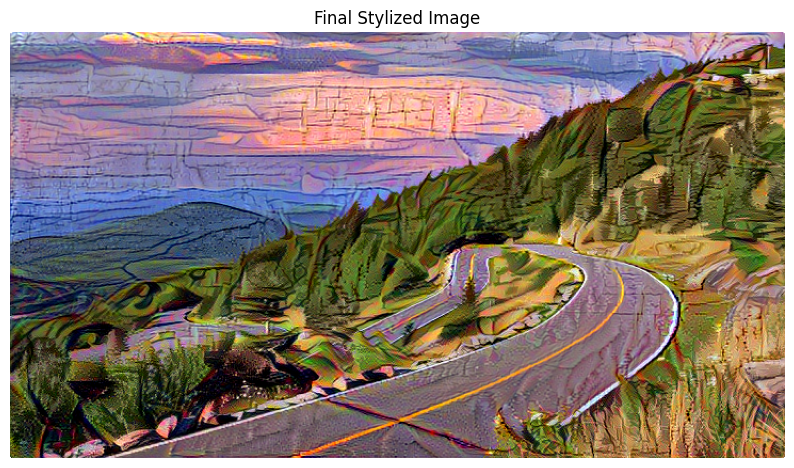

In [18]:
    
# Display the resulting image.
plt.figure(figsize=(10,10))
plt.imshow(result_image)
plt.title("Final Stylized Image")
plt.axis('off')
plt.show()

In [22]:
result_image2 = run_style_transfer(base_image_path, style_image_path, model_name='inceptionv3', iterations=3)

Start of iteration 0
Current loss value: 2496953088.0
Start of iteration 1
Current loss value: 1212996864.0
Start of iteration 2
Current loss value: 803125760.0


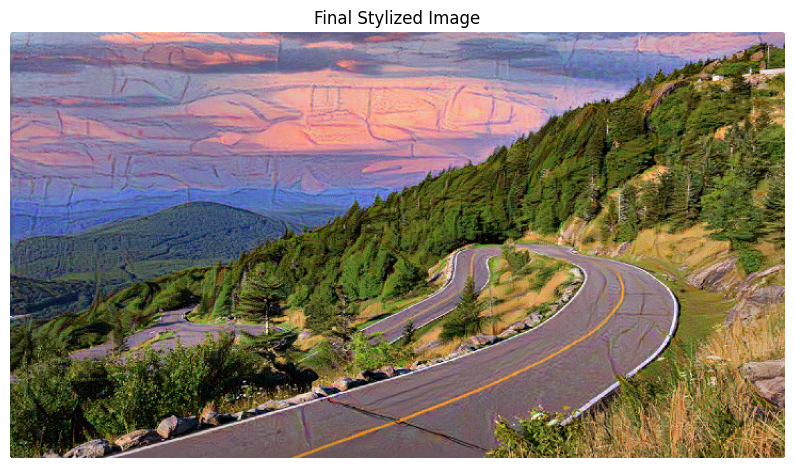

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(result_image2)
plt.title("Final Stylized Image")
plt.axis('off')
plt.show()

In [32]:
image1 = run_style_transfer( "/kaggle/input/new-pic/Screenshot 2025-02-19 at 11.10.15PM.png","/kaggle/input/best-artworks-of-all-time/images/images/Claude_Monet/Claude_Monet_16.jpg", model_name='vgg19', iterations=1)

Start of iteration 0
Current loss value: 2.4891839870939934e+21


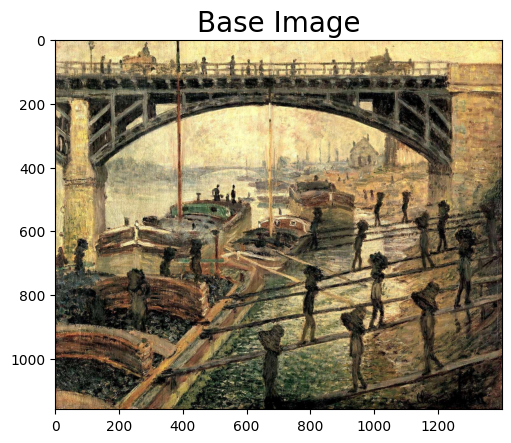

In [31]:
# plt.imshow("/kaggle/input/best-artworks-of-all-time/images/images/Claude_Monet/Claude_Monet_16.jpg")
# plt.imshow("/kaggle/input/new-pic/Screenshot 2025-02-19 at 11.10.15PM.png")
# plt.show()
plt.figure()
plt.title("Style Image",fontsize=20)
img2 = load_img("/kaggle/input/best-artworks-of-all-time/images/images/Claude_Monet/Claude_Monet_16.jpg")
plt.imshow(img2)

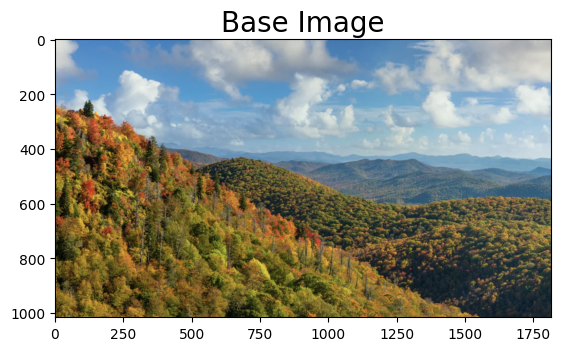

In [33]:
plt.figure()
plt.title("Base Image",fontsize=20)
img3 = load_img("/kaggle/input/new-pic/Screenshot 2025-02-19 at 11.10.15PM.png")
plt.imshow(img3)

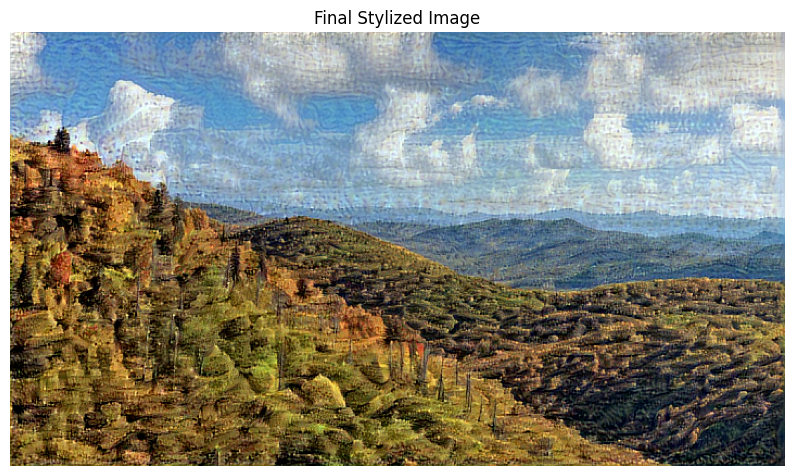

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(image1)
plt.title("Final Stylized Image")
plt.axis('off')
plt.show()